In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import imutils

## In this file, we create a neural network with one hidden layer and apply it to the mnist dataset in order to address the classification problem.


Using TensorFlow backend.


In [2]:
# loading mnist and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# network parameters
batch_size = 128
num_classes = 10
epochs = 20

# dimensions for the NN:
# input dimension
Q = x_train.shape[1]
# hidden layer dimension
K = 100
# output dimension : classification
D = num_classes

# dropout rate
p = 0.5
N = x_train.shape[0]
# l2 regularization
#prior length scale
l = 1e-2
# precision parameter, un peu au pif pour l'instant
tau = 1e-1

lambd = p*l**2/(2*N)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(60000, 28, 28) (60000,) (10000, 28, 28)
60000 train samples
10000 test samples


## Create a sequential model with Keras 

In [3]:
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd),
               bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(p))
# softmax layer
model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(p))
model.add(Activation('softmax'))

In [4]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 79,500
Trainable params: 79,500
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Training the network
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

In [6]:
# Evaluation of the network
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.131393762927
Test accuracy: 0.9669


## Obtaining model uncertainty

In [7]:
def my_relu(x):
    return x*(x>=0)

def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def softmax(x):
    norm = np.sum([np.exp(e) for e in x])
    return np.array([np.exp(e)/norm for e in x])

def softmax_in_out(x, model, nb_cl, T = 100) :
    W1, b, W2 = model.get_weights()
    S_in = np.zeros((T, nb_cl))
    S_out = np.zeros((T, nb_cl))
    
    for i in range(T):
        z1 = np.diag(np.random.rand(W1.shape[0]) > 0.5)
        z2 = np.diag(np.random.rand(W2.shape[0]) > 0.5)
        pred = np.dot(my_relu(np.dot(x, np.dot(z1, W1)) + b), np.dot(z2, W2))
        S_in[i] = pred
        S_out[i] = softmax(pred)
    return S_in, S_out
"""
"return the k most predicted classes"
def best_preds(S, k):
    preds = np.unique(np.argmax(S_out, axis= 1), return_counts= True)
    classes = dict(zip(preds[1], preds[0]))
    best_classes = [classes[e] for e in np.sort(preds[1])[-3:]]
    return best_classes[::-1]
"""
"return the dropout model prediction"
def dropout_pred(x, model, nb_cl, label = False):
    S_out = softmax_in_out(x, model, nb_cl)[1]
    pred = np.mean(S_out, axis = 0)
    if label == False:
        return(pred)
    else:
        return np.argmax(pred)    

## Vizualise data points

In [8]:
# graphical functions to display the distribution of the predictions
"""
input:  S, a sample of predictions (T forward passes) of size Txnum_classes for an image
        classes, the classes for which displaying the probability distributions
output: The plot of the distributions of the predicted probabilities for the desired classes
"""

def plot_pred(S, classes, yp = 0, legend = False):
    mapc = cm.tab10
    colors = dict(zip(classes, mapc.colors[:len(classes)]))
    #plt.figure(figsize= (8, 2))
    for cl in classes:
        plt.scatter(x = S[:,cl], y = np.array([1]*S.shape[0])*yp, label = cl, marker= '|', c = colors[cl], linewidth  = 2)
    for cl in classes:
        plt.scatter(x = np.mean(S[:,cl]), y = yp, c = colors[cl], linewidths= 4)
    if legend:plt.legend()
    return

# Wrapper function for plotting the image and the distribution, not useful anymore, expect
def plot_pred_img(x, model, nb_class, S = 'softmax_out', yp = 0):
    classes = np.argsort(model.predict(x.reshape(1,-1))[0])[-3:]
    S_in, S_out = softmax_in_out(x, model, nb_cl=10)
    fig = plt.figure(figsize = (10,2))
    gs =gridspec.GridSpec(1,2, width_ratios= [7,1])
    a = plt.subplot(gs[0])
    if S == 'softmax_out':
        plot_pred(S_out, classes, yp, legend = True)
    elif S == 'softmax_in':
        plot_pred(S_in, classes, yp, legend = True)
    b = plt.subplot(gs[1])
    x_pl = x.reshape((28,28))
    plt.imshow(x_pl, cmap = "gray")
    #plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.setp([b.get_xticklabels(), b.get_yticklabels(), a.get_yticklabels()], visible = False)
    return 

"""
Function to plot an image and its predicted class for several rotations of the image
input:  x, the input image
        m, the trained network model,
        nb_class, the number of prediction classes
        S, to plot the output or input of the softmax layer (either 'softmax_in' or 'softmax_out')
output: the plot 
"""
def plot_rotated(x, model, nb_class, S = 'softmax_out'):
    classes = np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
    nb_rotations = 6
    x_pl = x.reshape((28,28))
    x_rotated = [imutils.rotate(x_pl, r) for r in np.linspace(0,180, nb_rotations)]
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(nb_rotations, nb_rotations)
    ax1 = plt.subplot(gs[:,:-1])
    for (i, x) in zip((np.arange(nb_rotations)), x_rotated):        
        S_in, S_out = softmax_in_out(x.reshape((1,784)), model, nb_cl=nb_class)
        # trick to show legend only once 
        l = False
        if i == 0:l = True
        if S == 'softmax_out':
            plot_pred(S_out, classes, yp = -i, legend=l)
        elif S == 'softmax_in':
            plot_pred(S_in, classes, yp = -i, legend=l)
    for (i, x) in zip(np.arange(nb_rotations), x_rotated):
        plt.subplot(gs[i, -1])
        plt.imshow(x, cmap = 'gray')
    # remove uninteresting axes
    plt.setp([b.get_yticklabels() for b in fig.axes], visible = False)
    plt.setp([b.get_xticklabels() for b in fig.axes[1:]], visible = False)
    plt.show()
    return

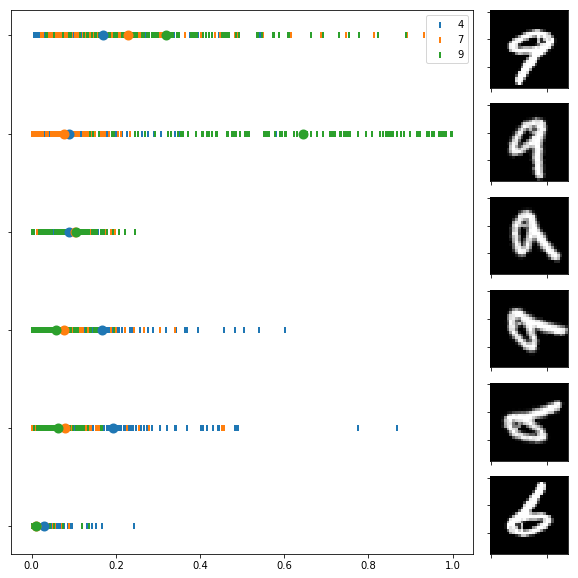

In [9]:
ix = 9
x_ex = x_test[ix]
#plot_pred_img(x_ex, model, nb_class=10)
#plt.show()
plot_rotated(x_ex, model , nb_class=10)
plt.show()

[[  6.15607121e-08   1.83305922e-08   8.92648586e-06   3.90280729e-06
    3.31138051e-03   7.77800415e-06   1.74647141e-07   6.06109947e-03
    9.13815893e-05   9.90515232e-01]]


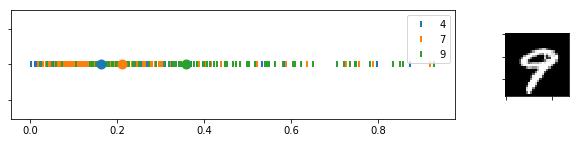

In [10]:
print(model.predict(x_ex.reshape(1,-1)))
np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
plot_pred_img(x_ex, model, nb_class=10)
plt.show()

Network prediction: [[  8.09264762e-08   5.69673649e-11   3.59074807e-06   3.98748128e-08
    4.48710608e-07   7.71844804e-01   2.28145719e-01   3.51860424e-12
    5.23515109e-06   8.40568504e-08]]
Networ label: 5
dropout prediction: [ 0.01485456  0.01060505  0.04084658  0.01584981  0.06908517  0.5506716
  0.24012306  0.004714    0.03492635  0.0183238 ]
dropout label: 5
real label: 5


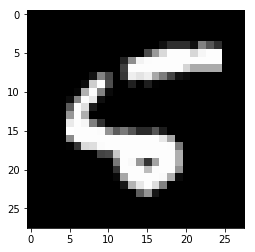

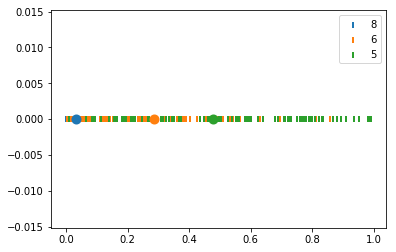

In [11]:
ix = 8
x_ex = x_test[ix]
print("Network prediction: " + str(model.predict(x_ex.reshape((1, -1)))))
print("Networ label: "+ str(np.argmax(model.predict(x_ex.reshape((1, -1))))))

print("dropout prediction: "+ str(dropout_pred(x_ex, model, nb_cl=10)))
print("dropout label: "+ str(dropout_pred(x_ex, model, nb_cl=10, label=True)))

print("real label: " + str(np.argmax(y_test[ix])))

x_pl = x_ex.reshape((28,28))
plt.imshow(x_pl, cmap = "gray")
plt.show()

classes = np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
S_in, S_out = softmax_in_out(x_ex, model, nb_cl=10)
plot_pred(S_out, classes, legend=True)
plt.show()